# Dataset with Bootstrapping Logic

In [441]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

from copy import deepcopy

torch.manual_seed(42)

rand = torch.randn(100, 1)

class NoisySineDataset(Dataset):
    def __init__(self, num_points=100, noise_level=0.0, lim=4):
        self.x = torch.linspace(-lim, lim, num_points).view(-1, 1)
        self.y = torch.sin(self.x*np.pi) + rand[:self.x.shape[0]] * noise_level

        #plt.plot(self.x[:,0].numpy(),self.y[:,0].numpy())
        #plt.show()
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# This custom collate function creates a unique batch for EACH model
def ensemble_collate_fn(batch_list, num_models):
    # We want to sample 'batch_size' items for each of the 'num_models'
    # To keep it simple, we'll just shuffle and reshape if the pool is big enough,
    # or randomly sample with replacement (Bootstrap).
    xs, ys = zip(*batch_list)
    xs, ys = torch.stack(xs), torch.stack(ys)
    
    # Randomly sample for each model (Bootstrap logic)
    # Resulting shape: [num_models, batch_size, 1]
    batch_size = len(batch_list)
    indices = torch.randint(0, batch_size, (num_models, batch_size))
    
    return xs[indices], ys[indices]

# Vectorized Ensemble Model

In [397]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 128), nn.ReLU(),
            nn.Linear(128, 1)
        )
    def forward(self, x): return self.net(x)

base_model = MLP()

# Training setup

In [398]:
def model_forward(params, buffers, x):
    return torch.func.functional_call(base_model, (params, buffers), x)

# Now vmap maps over BOTH params and the different data batches
# in_dims=(0, 0, 0) means: 
#   - 1st 0: map over param stack
#   - 2nd 0: map over buffer stack
#   - 3rd 0: map over the batch dimension of X
train_vmap = torch.func.vmap(model_forward, in_dims=(0, 0, 0))
eval_vmap = torch.func.vmap(model_forward, in_dims=(0, 0, None))

# Test vectorized vs traditional forward
This test is just to check the GPU memory alignment makes the computation consistent (this is related to JIT Warmup kind of stuff). You can skip if you don't care about reproducibility...

In [414]:
def compute_comparison_statistics(array1, array2):
    sorted_array_diff = np.sort(array1) - np.sort(array2)
    return sorted_array_diff.mean(), sorted_array_diff.std()

def compute_comparison_statistics_tradi(array1, array2):
    return (array1 - array2).mean(), (array1 - array2).std()

def evaluate_tradi(models, n_points=1000, lim=7):
    x_test = torch.linspace(-lim, lim, n_points).view(-1, 1)
    y_true = torch.sin(x_test*np.pi)

    mse_per_model = -np.ones(len(models))
    with torch.inference_mode():
        
        # Calculate loss per model relative to ground truth
        # mse_per_model shape: [num_models]
        mse_per_model = []

        for model in models:
            predictions = model(x_test)
            mse_per_model.append(torch.mean((predictions - y_true)**2))

        mse_per_model = np.array(mse_per_model)
        
        # Calculate the statistics over the inits
        mean_loss = mse_per_model.mean().item()
        std_loss = mse_per_model.std().item()

        print(f"mean_mse={mean_loss}, std_mse={std_loss}")
    
    return mse_per_model

def evaluate(params, buffers, n_points=1000, lim=7):
    x_test = torch.linspace(-lim, lim, n_points).view(-1, 1)
    y_true = torch.sin(x_test*np.pi)

    mse_per_model = -np.ones(len(params))
    with torch.inference_mode():
        predictions = eval_vmap(params, buffers, x_test)
        
        # Calculate loss per model relative to ground truth
        # mse_per_model shape: [num_models]
        mse_per_model = ((predictions - y_true)**2).mean(dim=(1, 2)).numpy()

        # Calculate the statistics over the inits
        mean_loss = mse_per_model.mean().item()
        std_loss = mse_per_model.std().item()

        print(f"mean_mse={mean_loss}, std_mse={std_loss}")
    
    return mse_per_model

def test_vectorized_vs_tradi(num_models=5):
    models = [MLP() for _ in range(num_models)]
    params, buffers = torch.func.stack_module_state(models)
    mse_per_model_tradi = evaluate_tradi(deepcopy(models), n_points=1000)
    mse_per_model = evaluate(params, buffers, n_points=1000)

    mean, std = compute_comparison_statistics_tradi(mse_per_model_tradi, mse_per_model)
    print("Statistics with the traditional method :")
    print(f"Mean Difference: {mean}")
    print(f"Std Difference: {std}")

    print("Statistics with the vectorized method :")
    mean, std = compute_comparison_statistics(mse_per_model_tradi, mse_per_model)
    print(f"Mean Difference: {mean}")
    print(f"Std Difference: {std}")

test_vectorized_vs_tradi()

mean_mse=0.5037814378738403, std_mse=0.003940287046134472
mean_mse=0.5037814378738403, std_mse=0.003940287046134472
Statistics with the traditional method :
Mean Difference: 0.0
Std Difference: 0.0
Statistics with the vectorized method :
Mean Difference: 0.0
Std Difference: 0.0


# Test Adam VS AdamW
## OOD generalization test

evaluating method Adam


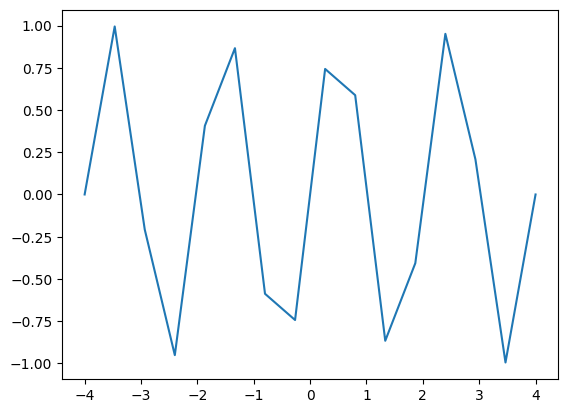

epoch=499 : loss=0.41575342416763306
epoch=999 : loss=0.49850916862487793
epoch=1499 : loss=0.5175952911376953
epoch=1999 : loss=0.44676685333251953
epoch=2499 : loss=0.512200653553009
epoch=2999 : loss=0.4148889482021332
epoch=3499 : loss=0.47824200987815857
epoch=3999 : loss=0.43883123993873596
epoch=4499 : loss=0.40741175413131714
epoch=4999 : loss=0.5457502007484436
mean_mse=0.4995195269584656, std_mse=1.8485883629182354e-05


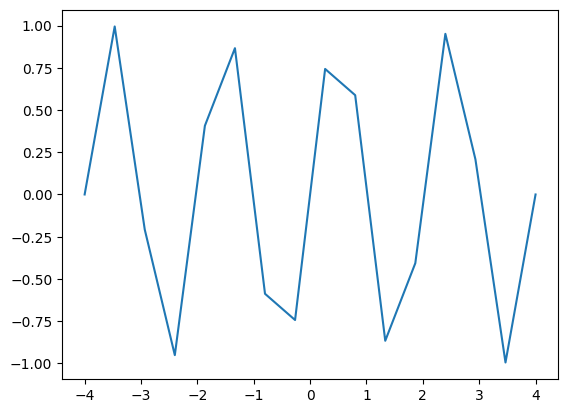

epoch=499 : loss=0.5101557970046997
epoch=999 : loss=0.50953209400177
epoch=1499 : loss=0.4471684396266937
epoch=1999 : loss=0.48726844787597656
epoch=2499 : loss=0.4695010781288147
epoch=2999 : loss=0.4381878972053528
epoch=3499 : loss=0.4958651065826416
epoch=3999 : loss=0.5057549476623535
epoch=4499 : loss=0.4932471215724945
epoch=4999 : loss=0.5049930810928345
mean_mse=0.4995187819004059, std_mse=2.4530016162316315e-05


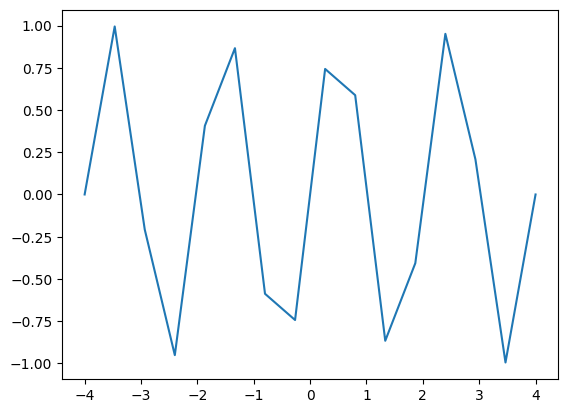

epoch=499 : loss=0.48230576515197754
epoch=999 : loss=0.4756045341491699
epoch=1499 : loss=0.4657719135284424
epoch=1999 : loss=0.4545566439628601
epoch=2499 : loss=0.5224124193191528
epoch=2999 : loss=0.47366294264793396
epoch=3499 : loss=0.4288516044616699
epoch=3999 : loss=0.4925846457481384
epoch=4499 : loss=0.5031594038009644
epoch=4999 : loss=0.4611746668815613
mean_mse=0.4995277523994446, std_mse=4.124366751057096e-05


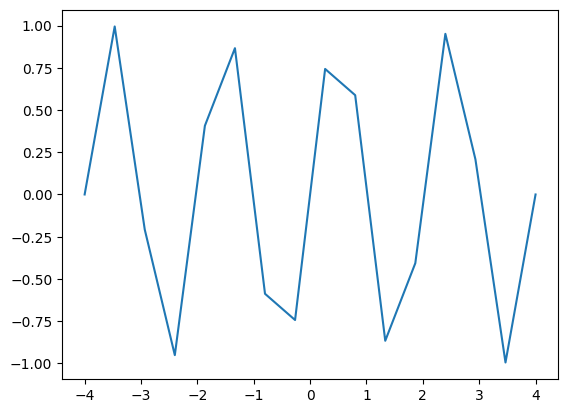

epoch=499 : loss=0.4711464047431946
epoch=999 : loss=0.46349436044692993
epoch=1499 : loss=0.4493107199668884
epoch=1999 : loss=0.38653478026390076
epoch=2499 : loss=0.46259719133377075
epoch=2999 : loss=0.4678434729576111
epoch=3499 : loss=0.41045626997947693
epoch=3999 : loss=0.4782586097717285
epoch=4499 : loss=0.47247791290283203
epoch=4999 : loss=0.46817532181739807
mean_mse=0.49971237778663635, std_mse=0.00016645890718791634


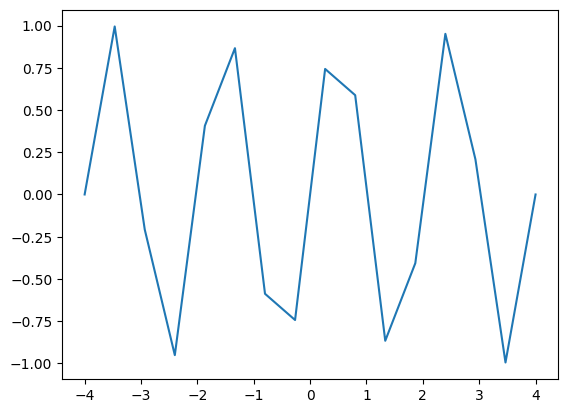

epoch=499 : loss=0.3109147548675537
epoch=999 : loss=0.09171341359615326
epoch=1499 : loss=0.0662643238902092
epoch=1999 : loss=0.019677918404340744
epoch=2499 : loss=0.007864074781537056
epoch=2999 : loss=0.022215109318494797
epoch=3499 : loss=0.00846034288406372
epoch=3999 : loss=0.008693424053490162
epoch=4499 : loss=0.003479163395240903
epoch=4999 : loss=0.0017243127804249525
mean_mse=0.24378137290477753, std_mse=0.027818340808153152


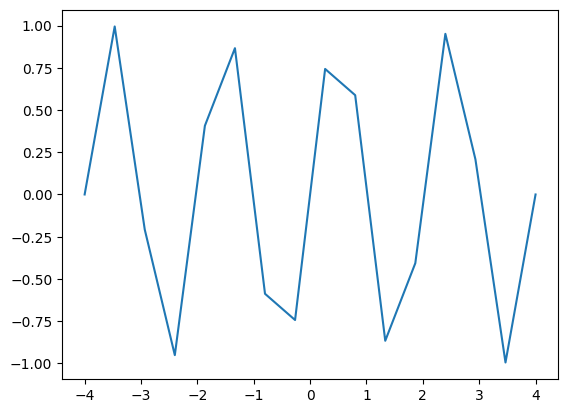

epoch=499 : loss=0.1544129103422165
epoch=999 : loss=0.05231431871652603
epoch=1499 : loss=0.038528721779584885
epoch=1999 : loss=0.0014707891969010234
epoch=2499 : loss=0.0006480241427198052
epoch=2999 : loss=0.0017653070390224457
epoch=3499 : loss=0.0011095682857558131
epoch=3999 : loss=0.0001915744214784354
epoch=4499 : loss=0.0009708881261758506
epoch=4999 : loss=0.001100017107091844
mean_mse=0.25467002391815186, std_mse=0.03775930777192116


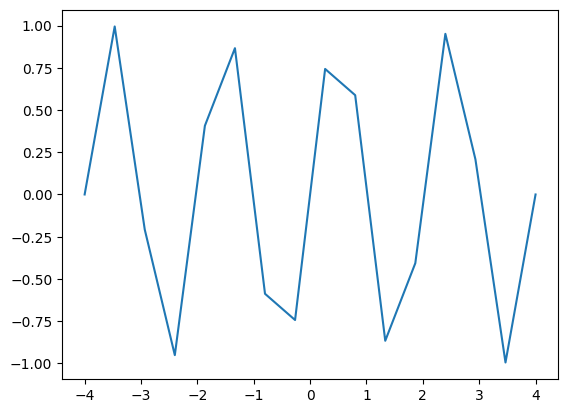

epoch=499 : loss=0.1174844279885292
epoch=999 : loss=0.0571880117058754
epoch=1499 : loss=0.004863021895289421
epoch=1999 : loss=0.0015811091288924217
epoch=2499 : loss=0.0001717427949188277
epoch=2999 : loss=0.0012195974122732878
epoch=3499 : loss=0.0006638009217567742
epoch=3999 : loss=0.014979449100792408
epoch=4499 : loss=9.226101246895269e-05
epoch=4999 : loss=0.0026618363335728645
mean_mse=0.279007226228714, std_mse=0.06058894470334053


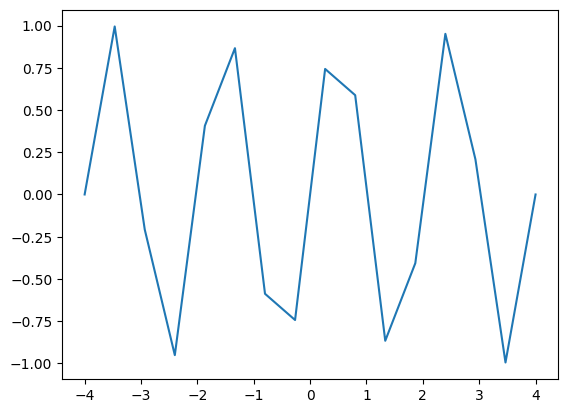

epoch=499 : loss=0.13136038184165955
epoch=999 : loss=0.05056040734052658
epoch=1499 : loss=0.007421554531902075
epoch=1999 : loss=1.616137524251826e-05
epoch=2499 : loss=0.0001606644655112177
epoch=2999 : loss=0.00032730732345953584
epoch=3499 : loss=0.00012683059321716428
epoch=3999 : loss=0.00014559806731995195
epoch=4499 : loss=0.00014930350880604237
epoch=4999 : loss=0.0004998139338567853
mean_mse=0.2708262503147125, std_mse=0.0826503187417984


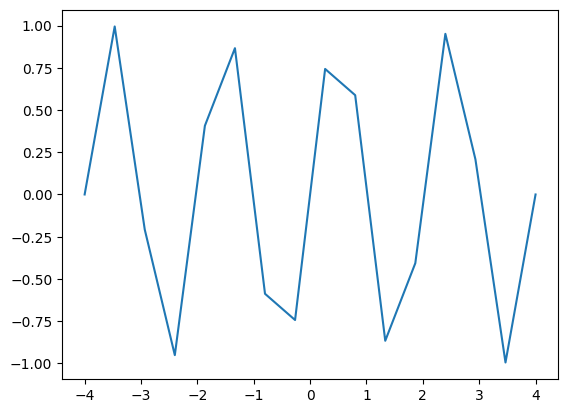

epoch=499 : loss=0.0819733515381813
epoch=999 : loss=0.04565172269940376
epoch=1499 : loss=0.0010693309595808387
epoch=1999 : loss=7.120810323613114e-07
epoch=2499 : loss=4.034066296298988e-05
epoch=2999 : loss=0.000464119017124176
epoch=3499 : loss=1.1245524547121022e-05
epoch=3999 : loss=0.0016289980849251151
epoch=4499 : loss=0.00016711522766854614
epoch=4999 : loss=0.00013503391528502107
mean_mse=0.3206726312637329, std_mse=0.0890706405043602


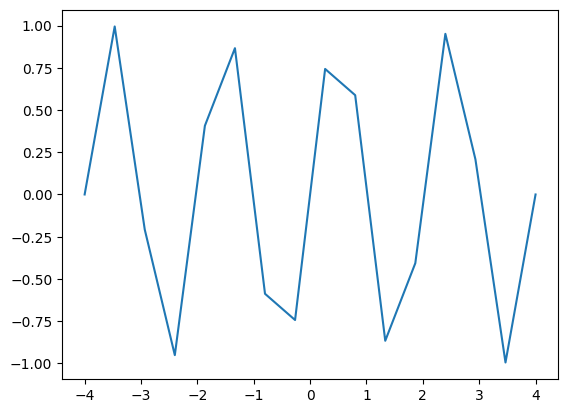

epoch=499 : loss=0.11029356718063354
epoch=999 : loss=0.03203878924250603
epoch=1499 : loss=0.011799105443060398
epoch=1999 : loss=0.00010792433749884367
epoch=2499 : loss=2.896940895880107e-05
epoch=2999 : loss=0.0001617004454601556
epoch=3499 : loss=1.9084773157374e-06
epoch=3999 : loss=1.7908405425259843e-05
epoch=4499 : loss=3.050457962672226e-05
epoch=4999 : loss=0.0026333481073379517
mean_mse=0.2751965820789337, std_mse=0.04191483184695244


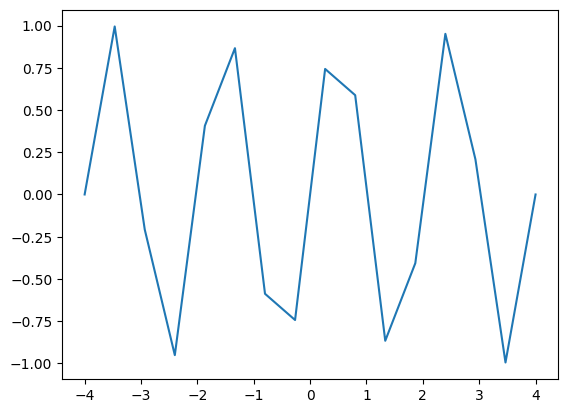

epoch=499 : loss=0.12597912549972534
epoch=999 : loss=0.036969054490327835
epoch=1499 : loss=0.0035047561395913363
epoch=1999 : loss=4.833963976125233e-05
epoch=2499 : loss=0.003452110569924116
epoch=2999 : loss=3.1033141567604616e-05
epoch=3499 : loss=0.0018840295961126685
epoch=3999 : loss=0.00010494152957107872
epoch=4499 : loss=0.001459811581298709
epoch=4999 : loss=8.339033229276538e-06
mean_mse=0.2772158980369568, std_mse=0.0767567902803421


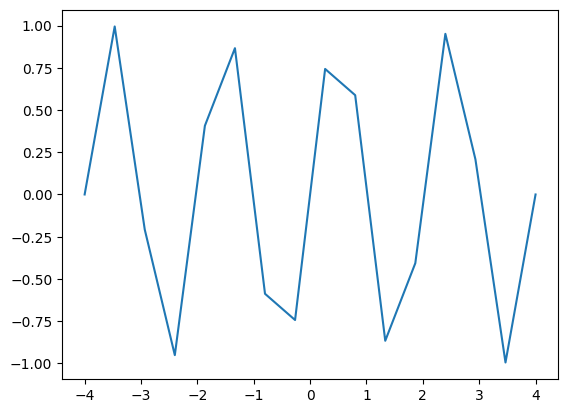

epoch=499 : loss=0.20108287036418915
epoch=999 : loss=0.04824211820960045
epoch=1499 : loss=0.0010379700688645244
epoch=1999 : loss=7.087977760278363e-09
epoch=2499 : loss=0.0006304556154645979
epoch=2999 : loss=0.0001880882919067517
epoch=3499 : loss=1.1513379831740167e-05
epoch=3999 : loss=0.0001325026823906228
epoch=4499 : loss=4.01558936573565e-05
epoch=4999 : loss=0.00017521156405564398
mean_mse=0.25889071822166443, std_mse=0.0236084945499897


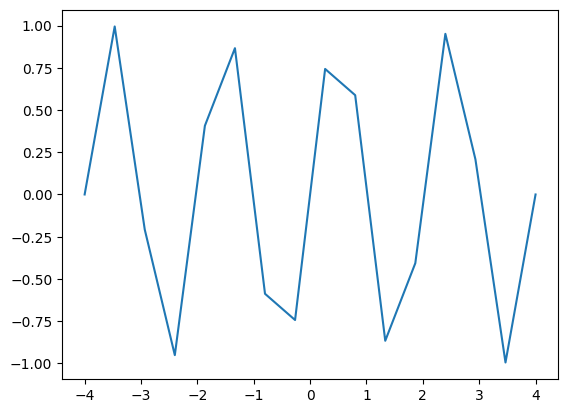

epoch=499 : loss=0.09728457033634186
epoch=999 : loss=0.0403091236948967
epoch=1499 : loss=0.00030562496976926923
epoch=1999 : loss=1.6222856391578944e-09
epoch=2499 : loss=8.380164118193534e-09
epoch=2999 : loss=0.00040874426485970616
epoch=3499 : loss=4.106376945856027e-05
epoch=3999 : loss=0.0006890891236253083
epoch=4499 : loss=0.00013852589472662657
epoch=4999 : loss=3.1502870115218684e-05
mean_mse=0.2723957598209381, std_mse=0.06236135959625244


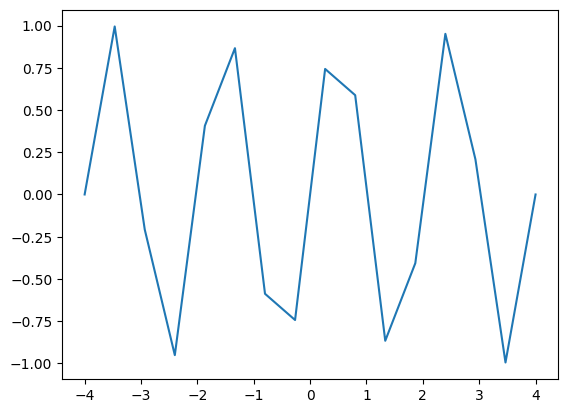

epoch=499 : loss=0.09559287130832672
epoch=999 : loss=0.04221178963780403
epoch=1499 : loss=0.006196632049977779
epoch=1999 : loss=1.488546956807113e-07
epoch=2499 : loss=0.000916055403649807
epoch=2999 : loss=0.006622816435992718
epoch=3499 : loss=3.742576518561691e-05
epoch=3999 : loss=8.575027459301054e-05
epoch=4499 : loss=1.3626776080855052e-06
epoch=4999 : loss=4.9923110054805875e-06
mean_mse=0.2955166697502136, std_mse=0.048115458339452744


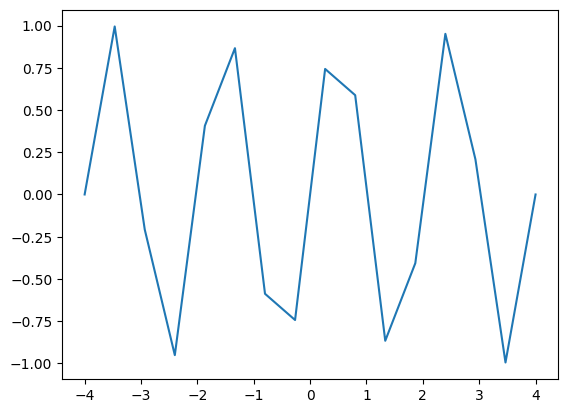

epoch=499 : loss=0.06294768303632736
epoch=999 : loss=0.043010301887989044
epoch=1499 : loss=0.001216114847920835
epoch=1999 : loss=0.001576475566253066
epoch=2499 : loss=8.354113928410456e-11
epoch=2999 : loss=4.625630390364677e-05
epoch=3499 : loss=9.932031161952182e-07
epoch=3999 : loss=0.00026382305077277124
epoch=4499 : loss=4.178824383416213e-06
epoch=4999 : loss=0.00012455896649044007
mean_mse=0.35952654480934143, std_mse=0.07537401467561722


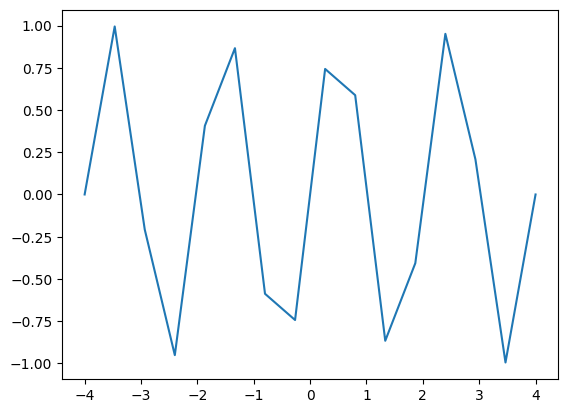

epoch=499 : loss=0.09485457837581635
epoch=999 : loss=0.038776278495788574
epoch=1499 : loss=0.00036530321813188493
epoch=1999 : loss=4.343188586553026e-10
epoch=2499 : loss=2.0807704856546684e-14
epoch=2999 : loss=3.321745073556377e-14
epoch=3499 : loss=4.801356823236347e-08
epoch=3999 : loss=5.2316558139864355e-05
epoch=4499 : loss=1.0390283478045603e-06
epoch=4999 : loss=0.005534143187105656
mean_mse=0.32353752851486206, std_mse=0.05957318842411041


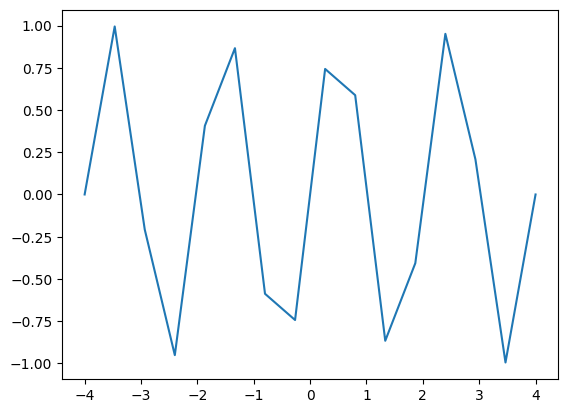

epoch=499 : loss=0.12321064621210098
epoch=999 : loss=0.033420246094465256
epoch=1499 : loss=0.0028284757863730192
epoch=1999 : loss=3.064217253267998e-07
epoch=2499 : loss=4.594375315576053e-15
epoch=2999 : loss=4.8641811437814386e-15
epoch=3499 : loss=8.077964329617025e-15
epoch=3999 : loss=4.656574469552241e-14
epoch=4499 : loss=0.0005844429833814502
epoch=4999 : loss=1.6327303455909714e-05
mean_mse=0.40120261907577515, std_mse=0.06277332454919815


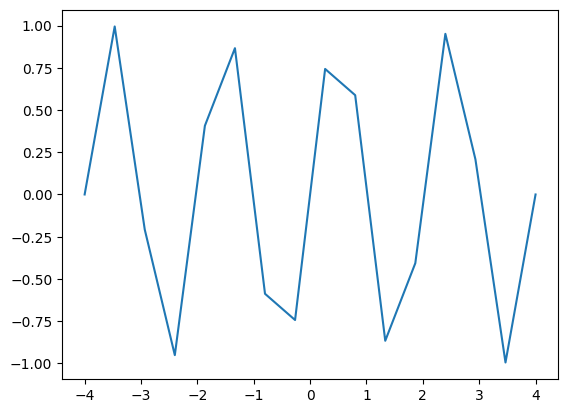

epoch=499 : loss=0.07247002422809601
epoch=999 : loss=0.062279172241687775
epoch=1499 : loss=0.011617003008723259
epoch=1999 : loss=0.005469904746860266
epoch=2499 : loss=3.467703209025785e-05
epoch=2999 : loss=3.6410611414794403e-07
epoch=3499 : loss=3.6814364057224935e-11
epoch=3999 : loss=2.728145354069511e-08
epoch=4499 : loss=6.284214032348245e-05
epoch=4999 : loss=2.8172380552859977e-05
mean_mse=0.40235400199890137, std_mse=0.06454403698444366


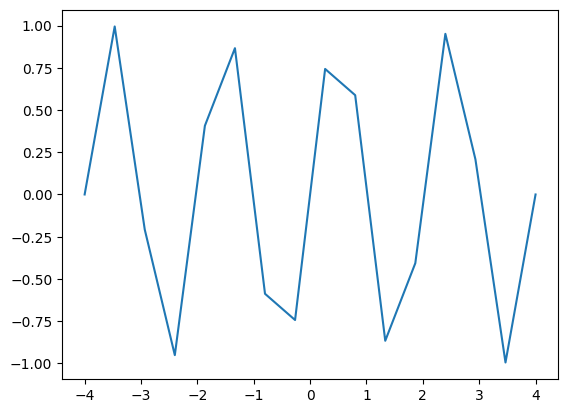

epoch=499 : loss=0.11865217983722687
epoch=999 : loss=0.04618345573544502
epoch=1499 : loss=0.003396301995962858
epoch=1999 : loss=6.130914664836951e-10
epoch=2499 : loss=6.679373173263878e-15
epoch=2999 : loss=7.140954460507689e-15
epoch=3499 : loss=7.167669032631142e-15
epoch=3999 : loss=5.526297128244373e-11
epoch=4499 : loss=5.5422271543648094e-05
epoch=4999 : loss=2.1745297829056653e-07
mean_mse=0.3134183883666992, std_mse=0.09573318809270859


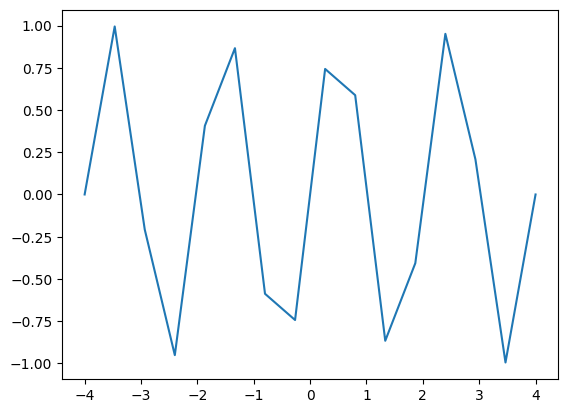

epoch=499 : loss=0.11487503349781036
epoch=999 : loss=0.03738590329885483
epoch=1499 : loss=0.002771188272163272
epoch=1999 : loss=8.067353007845668e-08
epoch=2499 : loss=2.2896897462487686e-06
epoch=2999 : loss=0.00016888670506887138
epoch=3499 : loss=0.00030871000490151346
epoch=3999 : loss=0.00012075443373760208
epoch=4499 : loss=2.9910603416283266e-07
epoch=4999 : loss=1.1720969084194621e-08
mean_mse=0.38659924268722534, std_mse=0.10012327134609222
evaluating method AdamW


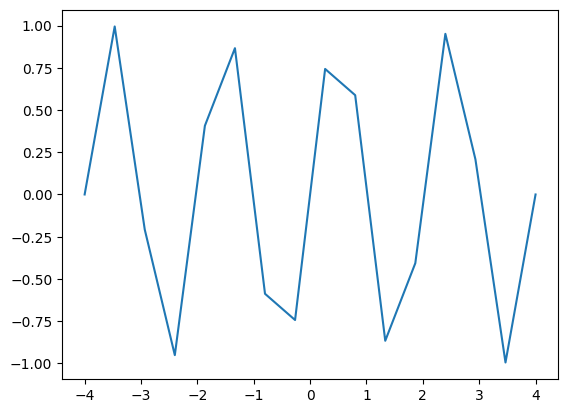

epoch=499 : loss=0.14036357402801514
epoch=999 : loss=0.02774689719080925
epoch=1499 : loss=8.968265319708735e-05
epoch=1999 : loss=1.4452380128204823e-05
epoch=2499 : loss=0.0004070645081810653
epoch=2999 : loss=0.00033556512789800763
epoch=3499 : loss=1.4269140592659824e-05
epoch=3999 : loss=0.0012213578447699547
epoch=4499 : loss=0.00014795426977798343
epoch=4999 : loss=4.643982902052812e-05
mean_mse=0.38900673389434814, std_mse=0.10025115311145782


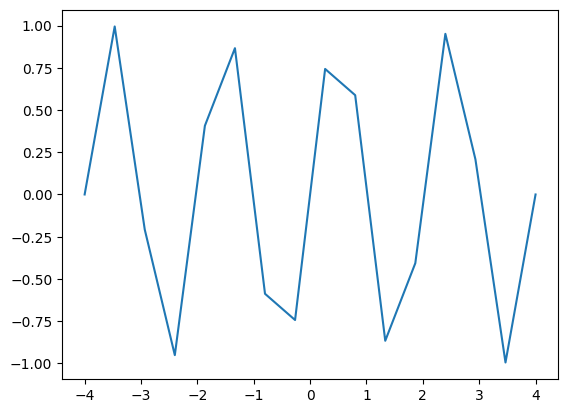

epoch=499 : loss=0.0696234181523323
epoch=999 : loss=0.027845000848174095
epoch=1499 : loss=0.001938234781846404
epoch=1999 : loss=1.3744422176387161e-05
epoch=2499 : loss=0.0004015995655208826
epoch=2999 : loss=2.9013372113695368e-05
epoch=3499 : loss=5.7835793995764107e-05
epoch=3999 : loss=0.007443723734468222
epoch=4499 : loss=0.00030166917713359
epoch=4999 : loss=7.942607044242322e-05
mean_mse=0.2941688895225525, std_mse=0.11199434846639633


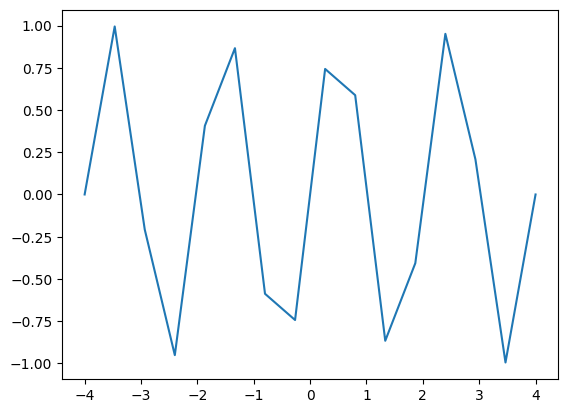

epoch=499 : loss=0.07488963752985
epoch=999 : loss=0.036922238767147064
epoch=1499 : loss=0.007397066801786423
epoch=1999 : loss=4.653857831726782e-05
epoch=2499 : loss=0.0003332658379804343
epoch=2999 : loss=4.234915104461834e-05
epoch=3499 : loss=1.0437619266667753e-06
epoch=3999 : loss=0.00044875405728816986
epoch=4499 : loss=0.0002013799676205963
epoch=4999 : loss=0.00016461418999824673
mean_mse=0.42467790842056274, std_mse=0.14726825058460236


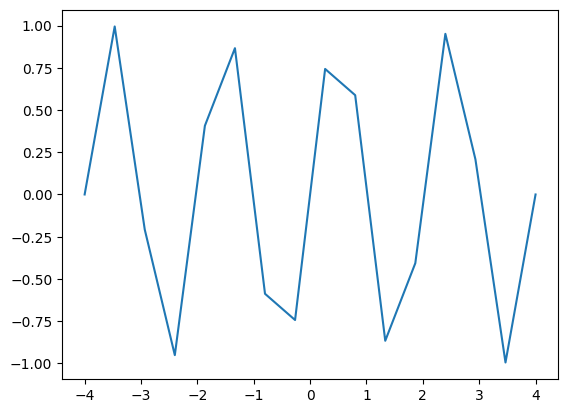

epoch=499 : loss=0.06667609512805939
epoch=999 : loss=0.019961882382631302
epoch=1499 : loss=0.0010549542494118214
epoch=1999 : loss=4.449179158427796e-08
epoch=2499 : loss=4.123191502003465e-06
epoch=2999 : loss=0.001911891857162118
epoch=3499 : loss=1.9042196072405204e-05
epoch=3999 : loss=0.00046959714381955564
epoch=4499 : loss=0.00030034856172278523
epoch=4999 : loss=1.1534278200997505e-05
mean_mse=0.3659816384315491, std_mse=0.06762155890464783


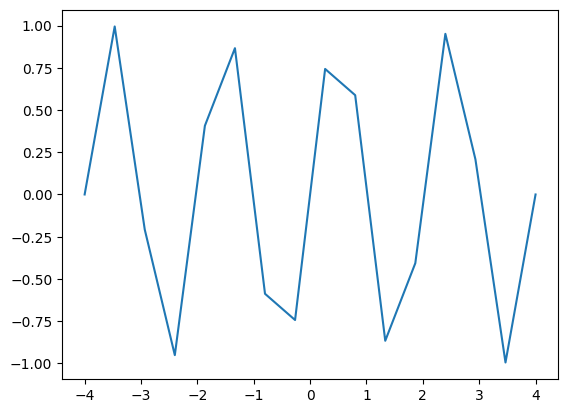

epoch=499 : loss=0.13048817217350006
epoch=999 : loss=0.039590947329998016
epoch=1499 : loss=0.00046589598059654236
epoch=1999 : loss=1.5372707551364329e-09
epoch=2499 : loss=1.3202536592871184e-06
epoch=2999 : loss=0.0012533343397080898
epoch=3499 : loss=0.0010852073319256306
epoch=3999 : loss=1.3337991731532384e-05
epoch=4499 : loss=4.32363485742826e-05
epoch=4999 : loss=0.00035047848359681666
mean_mse=0.3863823115825653, std_mse=0.07224774360656738


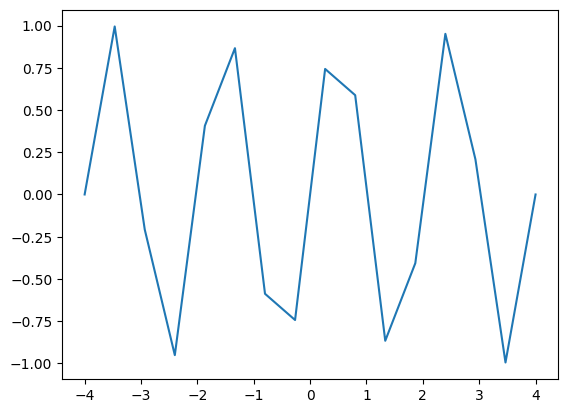

epoch=499 : loss=0.12208537757396698
epoch=999 : loss=0.027765080332756042
epoch=1499 : loss=0.00015875932876951993
epoch=1999 : loss=1.2053280595836213e-10
epoch=2499 : loss=2.0634091768556573e-08
epoch=2999 : loss=0.0001648589677643031
epoch=3499 : loss=6.0066095102229156e-06
epoch=3999 : loss=0.00043439833098091185
epoch=4499 : loss=5.4233555601967964e-06
epoch=4999 : loss=0.0007571804453618824
mean_mse=0.37793445587158203, std_mse=0.07465117424726486


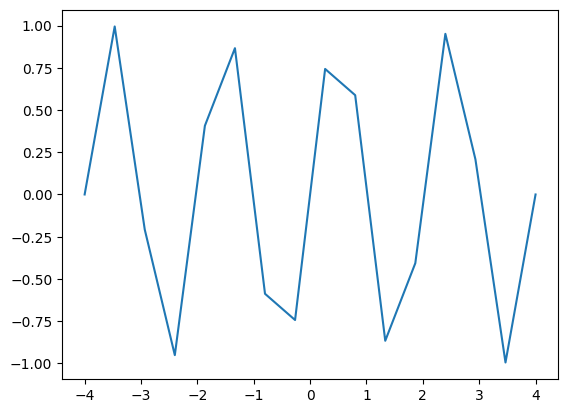

epoch=499 : loss=0.10870853811502457
epoch=999 : loss=0.033060770481824875
epoch=1499 : loss=0.015532066114246845
epoch=1999 : loss=0.000178421862074174
epoch=2499 : loss=3.1309821224567713e-06
epoch=2999 : loss=6.519223097711802e-05
epoch=3499 : loss=1.7930553440237418e-05
epoch=3999 : loss=3.478259895928204e-05
epoch=4499 : loss=0.0003700467641465366
epoch=4999 : loss=1.2443068726497586e-06
mean_mse=0.3085283935070038, std_mse=0.04155125841498375


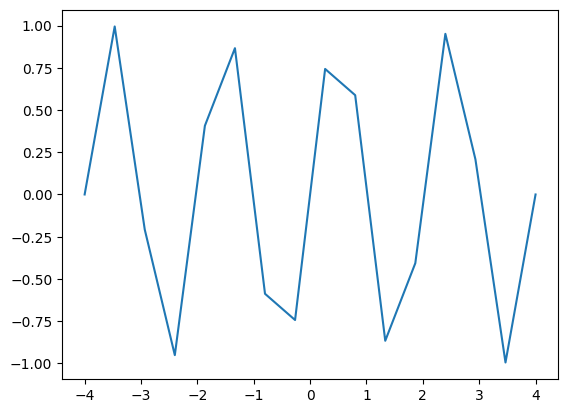

epoch=499 : loss=0.09106971323490143
epoch=999 : loss=0.015497714281082153
epoch=1499 : loss=0.007836183533072472
epoch=1999 : loss=8.52791259831065e-08
epoch=2499 : loss=0.00021107678185217083
epoch=2999 : loss=0.0006388109759427607
epoch=3499 : loss=1.4205662637323258e-06
epoch=3999 : loss=4.1277420677943155e-05
epoch=4499 : loss=3.718703374033794e-05
epoch=4999 : loss=1.6162696283572586e-06
mean_mse=0.27697306871414185, std_mse=0.03652309998869896


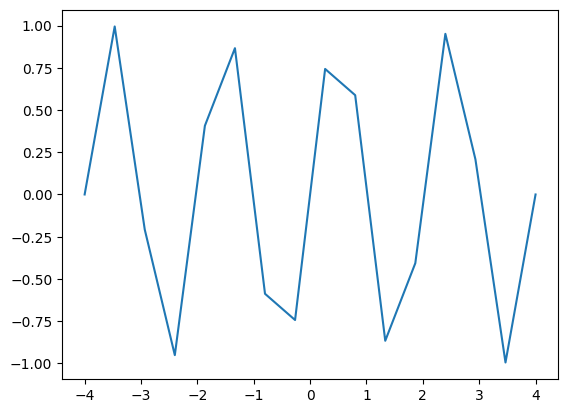

epoch=499 : loss=0.13138045370578766
epoch=999 : loss=0.025493353605270386
epoch=1499 : loss=2.0859555661445484e-05
epoch=1999 : loss=5.770372513147493e-10
epoch=2499 : loss=8.219437404477503e-06
epoch=2999 : loss=0.00017735379515215755
epoch=3499 : loss=9.866316395346075e-05
epoch=3999 : loss=0.00013626183499582112
epoch=4499 : loss=1.3218229923950275e-06
epoch=4999 : loss=4.248757250024937e-05
mean_mse=0.397057443857193, std_mse=0.07411935925483704


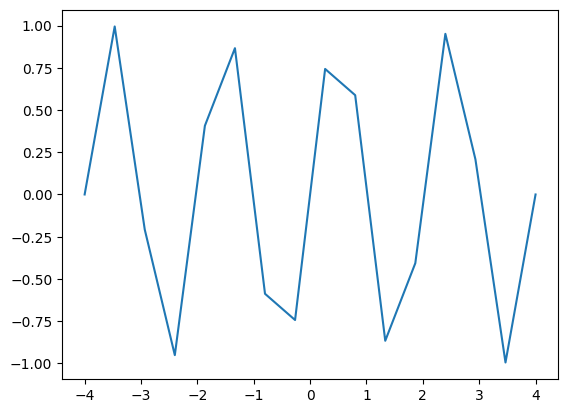

epoch=499 : loss=0.12862738966941833
epoch=999 : loss=0.024512827396392822
epoch=1499 : loss=0.00010658792598405853
epoch=1999 : loss=2.208598859354538e-10
epoch=2499 : loss=2.2791166998104018e-07
epoch=2999 : loss=0.00016471838171128184
epoch=3499 : loss=2.031632902799174e-06
epoch=3999 : loss=0.0036203861236572266
epoch=4499 : loss=3.5838767509233094e-09
epoch=4999 : loss=0.010486249811947346
mean_mse=0.4379405081272125, std_mse=0.07976911216974258


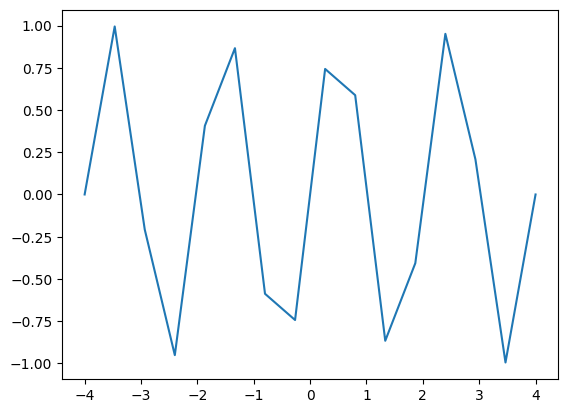

epoch=499 : loss=0.14349456131458282
epoch=999 : loss=0.046828653663396835
epoch=1499 : loss=0.002595537342131138
epoch=1999 : loss=4.213937700114911e-06
epoch=2499 : loss=1.3820060818393182e-14
epoch=2999 : loss=4.3191311123328205e-15
epoch=3499 : loss=4.857533205694913e-15
epoch=3999 : loss=1.0314789454968394e-14
epoch=4499 : loss=0.00033667520619928837
epoch=4999 : loss=0.006253062281757593
mean_mse=0.3582609295845032, std_mse=0.11217258870601654


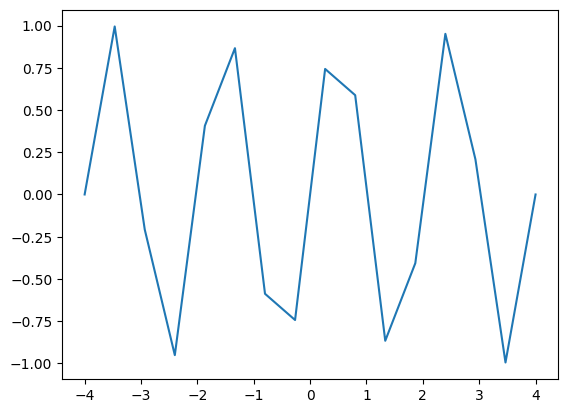

epoch=499 : loss=0.1044854149222374
epoch=999 : loss=0.035739049315452576
epoch=1499 : loss=0.004846624098718166
epoch=1999 : loss=1.385672817377781e-06
epoch=2499 : loss=1.3276912121801265e-12
epoch=2999 : loss=2.1795799511892255e-06
epoch=3499 : loss=4.2781117372214794e-05
epoch=3999 : loss=0.0006955349235795438
epoch=4499 : loss=0.00016727234469726682
epoch=4999 : loss=0.000134899266413413
mean_mse=0.3973461091518402, std_mse=0.08585557341575623


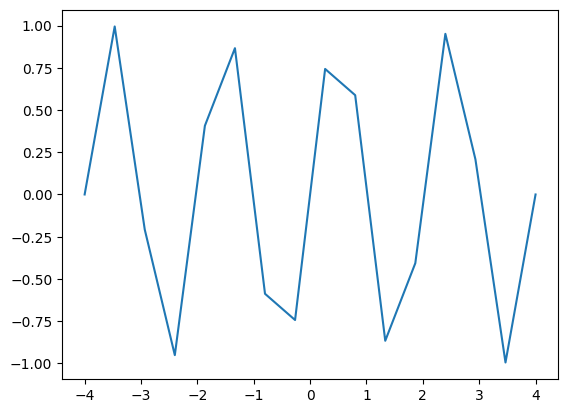

epoch=499 : loss=0.10333498567342758
epoch=999 : loss=0.023378217592835426
epoch=1499 : loss=8.114935553749092e-06
epoch=1999 : loss=2.404117460663713e-10
epoch=2499 : loss=1.584306687618664e-06
epoch=2999 : loss=5.726490948099183e-10
epoch=3499 : loss=4.113003611739413e-14
epoch=3999 : loss=6.972321716602892e-05
epoch=4499 : loss=0.0016072175931185484
epoch=4999 : loss=0.00017939881945494562
mean_mse=0.36061492562294006, std_mse=0.09745807945728302


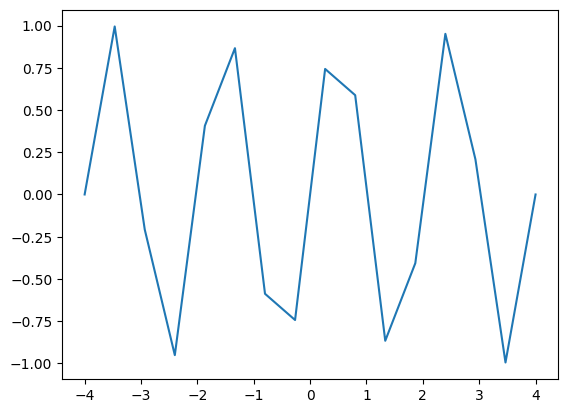

epoch=499 : loss=0.12179863452911377
epoch=999 : loss=0.04969719797372818
epoch=1499 : loss=0.001057937042787671
epoch=1999 : loss=1.6607006045887829e-06
epoch=2499 : loss=1.3715046407014597e-05
epoch=2999 : loss=0.00016567509737797081
epoch=3499 : loss=9.99888811747951e-07
epoch=3999 : loss=0.0006856232648715377
epoch=4499 : loss=2.0592647160810884e-06
epoch=4999 : loss=5.399724977905862e-05
mean_mse=0.37776845693588257, std_mse=0.11808676272630692


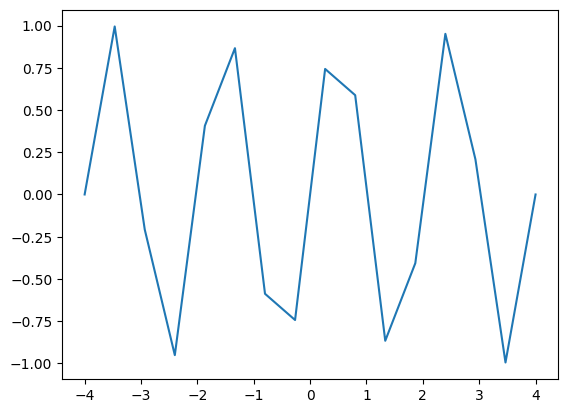

epoch=499 : loss=0.07525992393493652
epoch=999 : loss=0.025186389684677124
epoch=1499 : loss=0.0012799157993867993
epoch=1999 : loss=1.9666006600971286e-09
epoch=2499 : loss=1.0944927186784525e-09
epoch=2999 : loss=8.670058014104143e-05
epoch=3499 : loss=1.3012695490033366e-05
epoch=3999 : loss=0.000254113256232813
epoch=4499 : loss=0.0010808593360707164
epoch=4999 : loss=0.00010581615060800686
mean_mse=0.40826553106307983, std_mse=0.08398216217756271


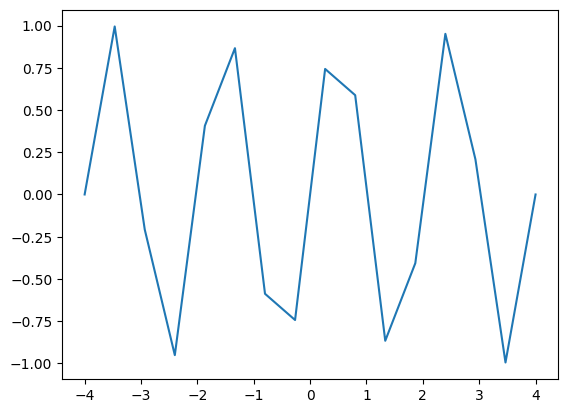

epoch=499 : loss=0.0879829004406929
epoch=999 : loss=0.04497288912534714
epoch=1499 : loss=0.0029757677111774683
epoch=1999 : loss=2.3250720460055163e-07
epoch=2499 : loss=6.61768695398024e-11
epoch=2999 : loss=0.0034796022810041904
epoch=3499 : loss=4.9784161092247814e-05
epoch=3999 : loss=0.0003618354385253042
epoch=4499 : loss=0.0009081627940759063
epoch=4999 : loss=0.0022423341870307922
mean_mse=0.430972158908844, std_mse=0.08263120800256729


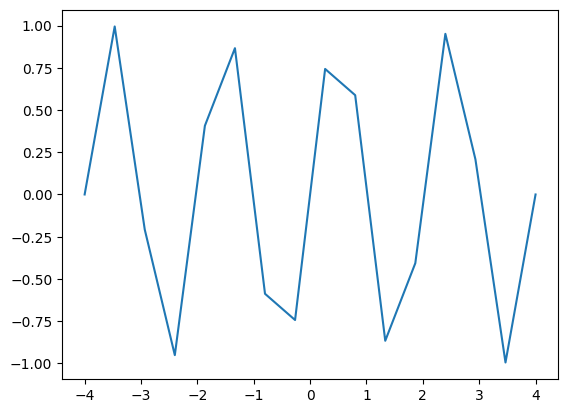

epoch=499 : loss=0.09654681384563446
epoch=999 : loss=0.03904528543353081
epoch=1499 : loss=0.003034320194274187
epoch=1999 : loss=1.9173414784745546e-06
epoch=2499 : loss=0.0009947143262252212
epoch=2999 : loss=0.0017458408838137984
epoch=3499 : loss=6.180858918014565e-07
epoch=3999 : loss=0.0028878238517791033
epoch=4499 : loss=1.7251260942430235e-05
epoch=4999 : loss=0.00035318307345733047
mean_mse=0.34067878127098083, std_mse=0.08478065580129623


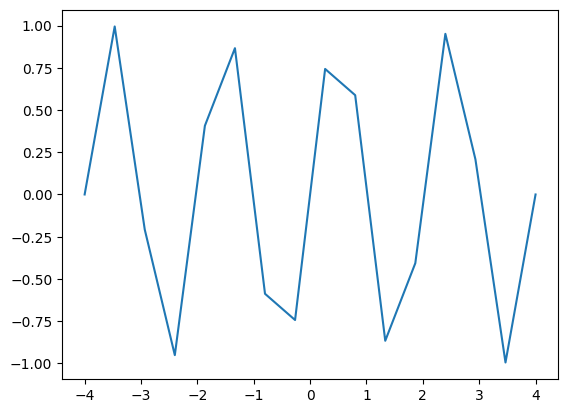

epoch=499 : loss=0.12181876599788666
epoch=999 : loss=0.02389446273446083
epoch=1499 : loss=0.0009063198231160641
epoch=1999 : loss=7.241315813644178e-08
epoch=2499 : loss=5.814244019575199e-08
epoch=2999 : loss=0.0004947081906720996
epoch=3499 : loss=1.039003564073937e-06
epoch=3999 : loss=3.5737724601858645e-07
epoch=4499 : loss=0.00044358536251820624
epoch=4999 : loss=5.5704656887201054e-08
mean_mse=0.41101303696632385, std_mse=0.06935005635023117


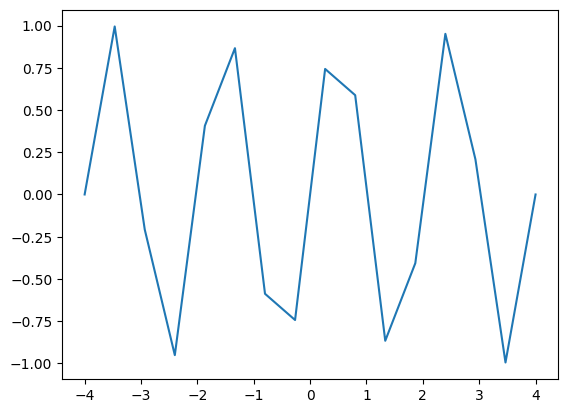

epoch=499 : loss=0.11333315074443817
epoch=999 : loss=0.04136129841208458
epoch=1499 : loss=0.00016842519107740372
epoch=1999 : loss=1.3119301651987048e-11
epoch=2499 : loss=1.7831360675936003e-15
epoch=2999 : loss=3.1698615629051352e-15
epoch=3499 : loss=5.0776990915429344e-15
epoch=3999 : loss=1.0513406985268592e-11
epoch=4499 : loss=0.000406988721806556
epoch=4999 : loss=1.5112967048480641e-05
mean_mse=0.38213104009628296, std_mse=0.10864207148551941


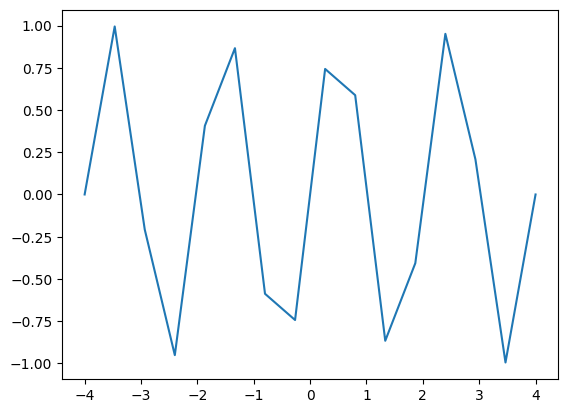

epoch=499 : loss=0.1124364584684372
epoch=999 : loss=0.02664131298661232
epoch=1499 : loss=0.0003887760976795107
epoch=1999 : loss=1.5160947497427912e-10
epoch=2499 : loss=2.243438990134905e-09
epoch=2999 : loss=0.0002113202353939414
epoch=3499 : loss=5.758575938281463e-15
epoch=3999 : loss=4.214940396707334e-09
epoch=4499 : loss=0.0002974453673232347
epoch=4999 : loss=1.1462765181491363e-09
mean_mse=0.345683753490448, std_mse=0.0689055323600769


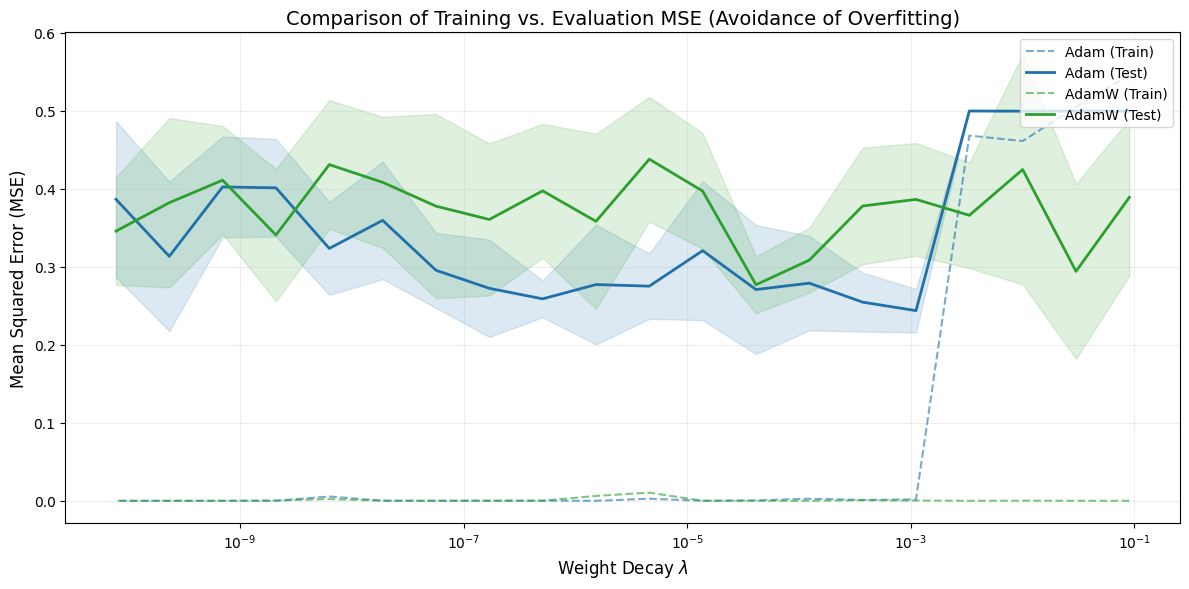

In [ ]:
import matplotlib.pyplot as plt

def test_optimizer(optimizer_type, learning_rate=0.002, weight_decay=0., epochs=100, num_inits=3):
    models = [MLP() for _ in range(num_inits)]
    params, buffers = torch.func.stack_module_state(models)

    dataset = NoisySineDataset(num_points=16)
    # We pass the full dataset to the collate_fn to sample from
    loader = DataLoader(
        dataset, 
        batch_size=16, 
        shuffle=True, 
        collate_fn=lambda b: ensemble_collate_fn(b, num_inits)
    )


    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([params[k] for k in params], lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.AdamW([params[k] for k in params], lr=learning_rate, weight_decay=weight_decay)

    last_training_loss = 0
    for epoch in range(epochs):
        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            
            # predictions shape: [num_models, batch_size, 1]
            predictions = train_vmap(params, buffers, batch_x)
            
            loss = nn.functional.mse_loss(predictions, batch_y)
            loss.backward()
            optimizer.step()

        last_training_loss = loss.item()
        if (epoch+1) % (epochs//10) == 0:
            print(f"epoch={epoch} : loss={last_training_loss}")

    mse_per_model = evaluate(params, buffers, n_points=1000)

    return mse_per_model, last_training_loss

def test_wdecay(wdecays, optimizers, colors, num_inits):
    mean_eval_mse, std_eval_mse, mean_train_mse = {}, {}, {}

    for opt_name in optimizers:
        print("evaluating method", opt_name)
        mean_eval_mse[opt_name] = []
        std_eval_mse[opt_name] = [] 
        mean_train_mse[opt_name] = []
        for wdecay in wdecays:
            mse_per_model, last_training_loss = test_optimizer(opt_name, epochs=5000, learning_rate=2e-4, weight_decay=wdecay, num_inits=num_inits)
            mean_eval_mse[opt_name].append(mse_per_model.mean())
            std_eval_mse[opt_name].append(mse_per_model.std())
            mean_train_mse[opt_name].append(last_training_loss)

    # Plotting
    plt.figure(figsize=(12, 6))

    for method in optimizers:
        # Plot Training Loss (Dashed)
        plt.plot(wdecays, mean_train_mse[method], linestyle='--', alpha=0.6, 
                color=colors[method], label=f'{method} (Train)')
        
        # Plot Evaluation Loss (Solid)
        plt.plot(wdecays, mean_eval_mse[method], linestyle='-', linewidth=2, 
                color=colors[method], label=f'{method} (Test)')
        
        # Plot Std Dev as shaded area for Eval Loss
        # Use alpha to make it transparent
        lower = np.array(mean_eval_mse[method]) - np.array(std_eval_mse[method])
        upper = np.array(mean_eval_mse[method]) + np.array(std_eval_mse[method])
        plt.fill_between(wdecays, lower, upper, color=colors[method], alpha=0.15)

    plt.title('Comparison of Training vs. Evaluation MSE (Avoidance of Overfitting)', fontsize=14)
    plt.xlabel('Weight Decay $\\lambda$', fontsize=12)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
    plt.xscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(loc='upper right')

    plt.tight_layout()

test_wdecay([0.09/3**i for i in range(20)], ["Adam", "AdamW"], {'Adam': "#2071AA", 'AdamW': '#2ca02c'}, 5)
#mse_per_model, last_t                                                                      76666666666665raining_loss = test_adam(epochs=1000, weight_decay=0.001)
#print(mse_per_model, last_training_loss)

## ID generalization test

In [435]:
class UNet1D(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.enc1 = nn.Linear(1, 128)
        self.enc2 = nn.Linear(128, 256)
        # Decoder
        self.dec2 = nn.Linear(256, 128)
        self.dec1 = nn.Linear(128 + 128, 1) # +128 for skip connection

    def forward(self, x):
        x1 = torch.relu(self.enc1(x))
        x2 = torch.relu(self.enc2(x1))
        
        y2 = torch.relu(self.dec2(x2))
        # Skip connection
        y1 = torch.cat([y2, x1], dim=-1) 
        return self.dec1(y1)

base_model = UNet1D()

def model_forward(params, buffers, x):
    return torch.func.functional_call(base_model, (params, buffers), x)

# Now vmap maps over BOTH params and the different data batches
# in_dims=(0, 0, 0) means: 
#   - 1st 0: map over param stack
#   - 2nd 0: map over buffer stack
#   - 3rd 0: map over the batch dimension of X
train_vmap = torch.func.vmap(model_forward, in_dims=(0, 0, 0))
eval_vmap = torch.func.vmap(model_forward, in_dims=(0, 0, None))

evaluating method Adam
epoch=499 : loss=0.34319987893104553
epoch=999 : loss=0.27672669291496277
epoch=1499 : loss=0.324337899684906
epoch=1999 : loss=0.2765805125236511
epoch=2499 : loss=0.21817505359649658
epoch=2999 : loss=0.22536662220954895
epoch=3499 : loss=0.29481053352355957
epoch=3999 : loss=0.35582831501960754
epoch=4499 : loss=0.31773778796195984
epoch=4999 : loss=0.21554426848888397
mean_mse=0.08135237544775009, std_mse=0.006933699827641249
epoch=499 : loss=0.23147323727607727
epoch=999 : loss=0.19088028371334076
epoch=1499 : loss=0.18940827250480652
epoch=1999 : loss=0.20805439352989197
epoch=2499 : loss=0.1590336412191391
epoch=2999 : loss=0.17796066403388977
epoch=3499 : loss=0.18460801243782043
epoch=3999 : loss=0.15795177221298218
epoch=4499 : loss=0.18200115859508514
epoch=4999 : loss=0.17914216220378876
mean_mse=0.09481433779001236, std_mse=0.008146402426064014
epoch=499 : loss=0.2371656447649002
epoch=999 : loss=0.18064992129802704
epoch=1499 : loss=0.15802137553691

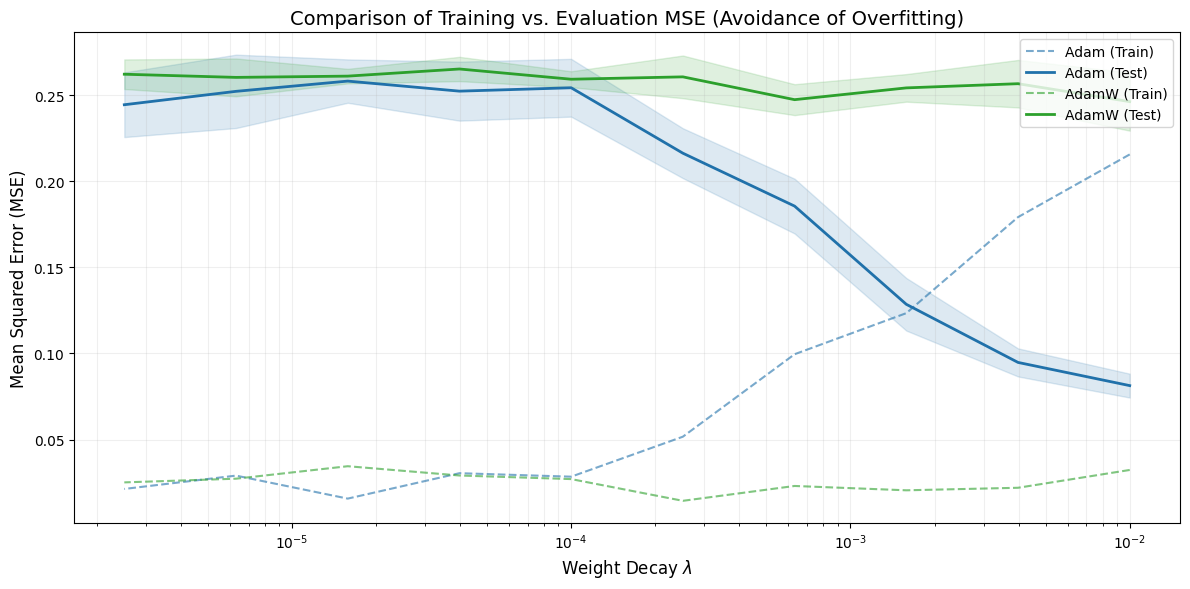

In [443]:
def test_optimizer(optimizer_type, learning_rate=0.002, weight_decay=0., epochs=100, num_inits=3):
    models = [UNet1D() for _ in range(num_inits)]
    params, buffers = torch.func.stack_module_state(models)

    dataset = NoisySineDataset(num_points=16, noise_level=0.5, lim=2/np.pi)
    # We pass the full dataset to the collate_fn to sample from
    loader = DataLoader(
        dataset, 
        batch_size=16, 
        shuffle=True, 
        collate_fn=lambda b: ensemble_collate_fn(b, num_inits)
    )


    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([params[k] for k in params], lr=learning_rate, weight_decay=weight_decay)
    else:
        optimizer = torch.optim.AdamW([params[k] for k in params], lr=learning_rate, weight_decay=weight_decay)

    last_training_loss = 0
    for epoch in range(epochs):
        for batch_x, batch_y in loader:
            optimizer.zero_grad()
            
            # predictions shape: [num_models, batch_size, 1]
            predictions = train_vmap(params, buffers, batch_x)
            
            loss = nn.functional.mse_loss(predictions, batch_y)
            loss.backward()
            optimizer.step()

        last_training_loss = loss.item()
        if (epoch+1) % (epochs//10) == 0:
            print(f"epoch={epoch} : loss={last_training_loss}")

    mse_per_model = evaluate(params, buffers, n_points=1000, lim=2/np.pi)

    return mse_per_model, last_training_loss

def test_wdecay(wdecays, optimizers, colors, num_inits):
    mean_eval_mse, std_eval_mse, mean_train_mse = {}, {}, {}

    for opt_name in optimizers:
        print("evaluating method", opt_name)
        mean_eval_mse[opt_name] = []
        std_eval_mse[opt_name] = [] 
        mean_train_mse[opt_name] = []
        for wdecay in wdecays:
            mse_per_model, last_training_loss = test_optimizer(opt_name, epochs=5000, learning_rate=2e-4, weight_decay=wdecay, num_inits=num_inits)
            mean_eval_mse[opt_name].append(mse_per_model.mean())
            std_eval_mse[opt_name].append(mse_per_model.std())
            mean_train_mse[opt_name].append(last_training_loss)

    # Plotting
    plt.figure(figsize=(12, 6))

    for method in optimizers:
        # Plot Training Loss (Dashed)
        plt.plot(wdecays, mean_train_mse[method], linestyle='--', alpha=0.6, 
                color=colors[method], label=f'{method} (Train)')
        
        # Plot Evaluation Loss (Solid)
        plt.plot(wdecays, mean_eval_mse[method], linestyle='-', linewidth=2, 
                color=colors[method], label=f'{method} (Test)')
        
        # Plot Std Dev as shaded area for Eval Loss
        # Use alpha to make it transparent
        lower = np.array(mean_eval_mse[method]) - np.array(std_eval_mse[method])
        upper = np.array(mean_eval_mse[method]) + np.array(std_eval_mse[method])
        plt.fill_between(wdecays, lower, upper, color=colors[method], alpha=0.15)

    plt.title('Comparison of Training vs. Evaluation MSE (Avoidance of Overfitting)', fontsize=14)
    plt.xlabel('Weight Decay $\\lambda$', fontsize=12)
    plt.ylabel('Mean Squared Error (MSE)', fontsize=12)
    plt.xscale('log')
    plt.grid(True, which="both", ls="-", alpha=0.2)
    plt.legend(loc='upper right')

    plt.tight_layout()

test_wdecay([(1e-2)*((1e-6)/(1e-2))**(i/10) for i in range(10)], ["Adam", "AdamW"], {'Adam': "#2071AA", 'AdamW': '#2ca02c'}, 5)